In [1]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
import mysql.connector
import os


csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]


conn = mysql.connector.connect(
    host='local****',
    user='root',
    password='**********',
    database='ecomm****'
)
cursor = conn.cursor()


folder_path = '/Users/prasad/Desktop/drive-download-20260126T151059Z-3-001'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    

    df = pd.read_csv(file_path)
    

    df = df.where(pd.notnull(df), None)
    

    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")


    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]


    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)


    for _, row in df.iterrows():

        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)


    conn.commit()


conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db = mysql.connector.connect(host ="local****", 
                             username ="root",
                             password ="**********",
                             database ="ecomm****")

cur = db.cursor()

In [17]:
import mysql.connector

conn = mysql.connector.connect(
    host="local****",
    user="root",
    password="**********",
    database="ecomm****"
)

cur = conn.cursor()
conn.reconnect()
cur = conn.cursor()



In [5]:
# List all unique cities where customers are located.
query=""" select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [6]:
# Count the number of orders placed in 2017.
query=""" select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are=", data[0][0]

('total orders placed in 2017 are=', 135303)

In [7]:
# Find the total sales per category.
query = """
SELECT
    p.product_category AS category,
    SUM(pay.payment_value) AS sales
FROM products p
JOIN order_items oi 
    ON p.product_id = oi.product_id
JOIN payments pay
    ON oi.order_id = pay.order_id
GROUP BY p.product_category;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Sales"])
df


,Category,Sales
0,perfumery,1.368194e+07
1,Furniture Decoration,3.861476e+07
2,telephony,1.314582e+07
3,bed table bath,4.623895e+07
4,automotive,2.301195e+07
...,...,...
69,cds music dvds,3.238461e+04
70,La Cuisine,7.866531e+04
71,Fashion Children's Clothing,2.121309e+04
72,PC Gamer,5.870961e+04


In [8]:
# Calculate the percentage of orders that were paid in installments.
query=""" select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('100.0000'))

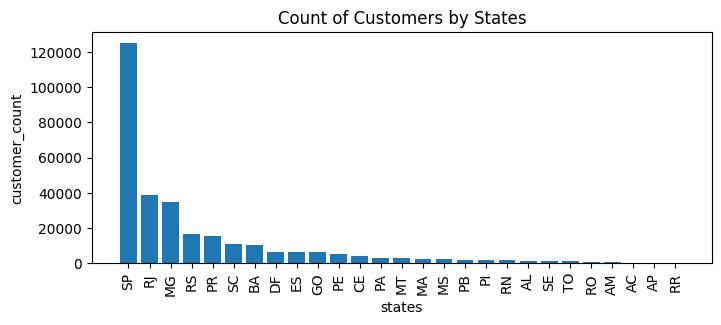

In [9]:
# Count the number of customers from each state. 
query=""" select customer_state, count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


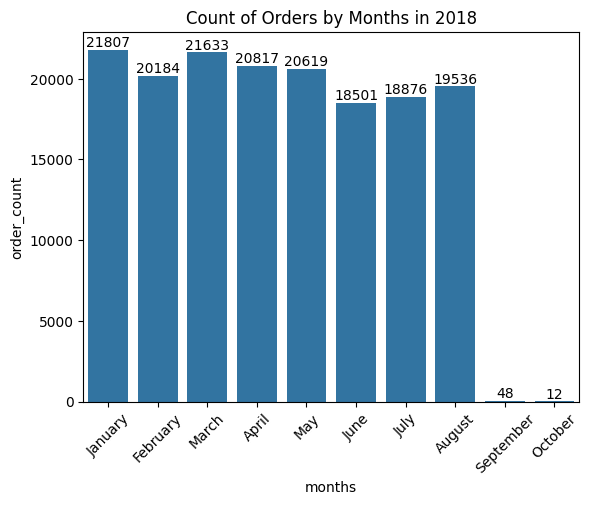

In [10]:
# Calculate the number of orders per month in 2018.
query=""" select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data =df, order = o)
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()

In [11]:
# Find the average number of products per order, grouped by customer city.
query=""" WITH count_per_order AS (
    SELECT 
        o.order_id,
        o.customer_id,
        COUNT(oi.order_id) AS order_count
    FROM orders o
    JOIN order_items oi
        ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id
)
SELECT 
    c.customer_city,
    AVG(cpo.order_count) AS avg_products_per_order
FROM count_per_order cpo
JOIN customers c
    ON cpo.customer_id = c.customer_id
GROUP BY c.customer_city;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer city", "average orders"])
df.head(10)

,Customer city,average orders
0,sao paulo,10.4059
1,sao jose dos campos,10.2464
2,porto alegre,10.5743
3,indaial,10.0385
4,treze tilias,11.4545
5,rio de janeiro,10.3209
6,mario campos,12.0000
7,guariba,9.0000
8,cuiaba,10.7782
9,franca,11.2642


In [12]:
# Calculate the percentage of total revenue contributed by each product category.
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
df = pd.DataFrame(data, columns = ["Category", "percentage distribution"])
df.head(10)

,Category,percentage distribution
0,sao paulo,10.4059
1,sao jose dos campos,10.2464
2,porto alegre,10.5743
3,indaial,10.0385
4,treze tilias,11.4545
5,rio de janeiro,10.3209
6,mario campos,12.0000
7,guariba,9.0000
8,cuiaba,10.7782
9,franca,11.2642


In [20]:
# Identify the correlation between product price and the number of times a product has been purchased.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(host ="local****", 
                             username ="root",
                             password ="**********",
                             database ="ecom*****")

cur = db.cursor()

cur = conn.cursor(buffered=True)

query = """
SELECT 
    p.product_category,
    COUNT(oi.product_id) AS order_count,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM products p
JOIN order_items oi
    ON p.product_id = oi.product_id
GROUP BY p.product_category;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(
    data,
    columns=["Category", "order_count", "avg_price"]
)

df


arr1 = df["order_count"]
arr2 = df["avg_price"]
a = np.corrcoef([arr1,arr2])
print("the corelation is", a[0][-1])

the corelation is -0.10631514167157564


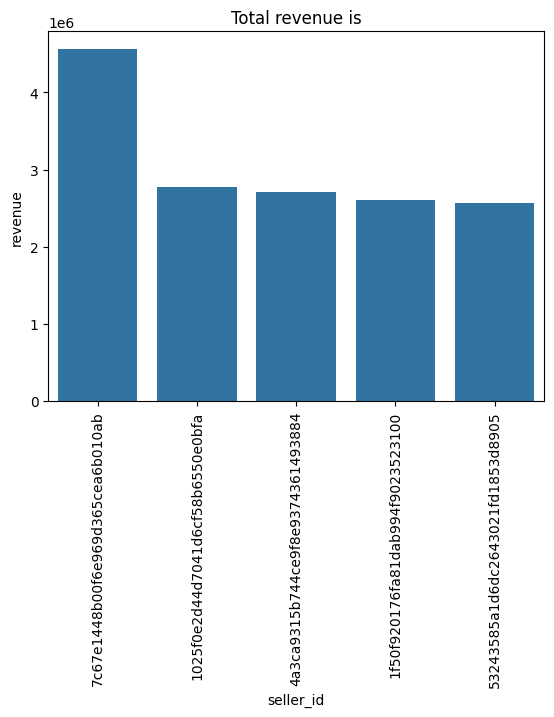

In [18]:
# Calculate the total revenue generated by each seller, and rank them by revenue.

query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y= "revenue", data = df)
plt.xticks(rotation=90)
plt.title("Total revenue is")
plt.show()

In [23]:
# Calculate the moving average of order values for each customer over their order history.
query = """SELECT
    o.customer_id,
    o.order_purchase_timestamp,
    p.payment_value,
    AVG(p.payment_value) OVER (
        PARTITION BY o.customer_id
        ORDER BY o.order_purchase_timestamp
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM payments p
JOIN orders o
    ON p.order_id = o.order_id;
"""
cur = conn.cursor(buffered=True)

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(
    data,
    columns=[
        "customer_id",
        "order_purchase_timestamp",
        "payment_value",
        "moving_avg"
    ]
)

df


,customer_id,order_purchase_timestamp,payment_value,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [26]:
# Calculate the cumulative sales per month for each year.
query = """ SELECT
    years,
    months,
    monthly_sales,
    SUM(monthly_sales) OVER (
        ORDER BY years, months
    ) AS cumulative_sales
FROM (
    SELECT
        YEAR(o.order_purchase_timestamp) AS years,
        MONTH(o.order_purchase_timestamp) AS months,
        SUM(p.payment_value) AS monthly_sales
    FROM orders o
    JOIN payments p
        ON o.order_id = p.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS t;
"""
cur = conn.cursor(buffered=True)

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(
    data,
    columns=["year", "month", "monthly_sales", "cumulative_sales"]
)

df


,year,month,monthly_sales,cumulative_sales
0,2016,9,2.270160e+03,2.270160e+03
1,2016,10,5.318143e+05,5.340845e+05
2,2016,12,1.765800e+02,5.342611e+05
3,2017,1,1.246392e+06,1.780653e+06
4,2017,2,2.627172e+06,4.407826e+06
5,2017,3,4.048772e+06,8.456598e+06
6,2017,4,3.760092e+06,1.221669e+07
7,2017,5,5.336269e+06,1.755296e+07
8,2017,6,4.601487e+06,2.215445e+07
9,2017,7,5.331446e+06,2.748589e+07


In [31]:
# Calculate the year-over-year growth rate of total sales.
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, payment, lag(payment, 1) over(order by years) from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "sales", "previous_year"])
df

,years,sales,previous_year
0,2016,534261.06,NaN
1,2017,65247720.55,534261.06
2,2018,78297867.47,65247720.55


In [33]:
# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
query = """ WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),

b AS (
    SELECT 
        orders.customer_id,
        orders.order_purchase_timestamp
    FROM orders
)

SELECT 
    COUNT(DISTINCT b.customer_id) * 100.0 / COUNT(DISTINCT a.customer_id) AS retention_rate
FROM a
LEFT JOIN b
    ON a.customer_id = b.customer_id
   AND b.order_purchase_timestamp > a.first_order
   AND b.order_purchase_timestamp <= DATE_ADD(a.first_order, INTERVAL 6 MONTH);
"""

cur.execute(query)
data = cur.fetchall()
data


[(Decimal('0.00000'),)]

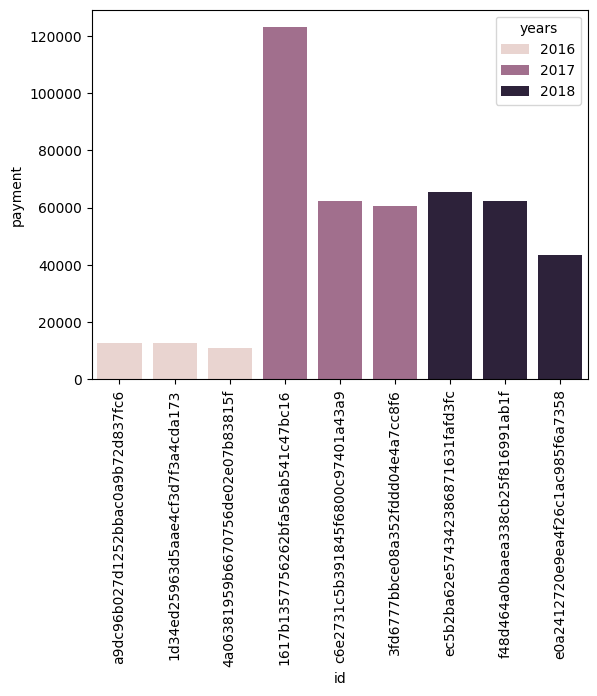

In [35]:
# Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()